# Thesis

In [ ]:
!pip install requests pytrends yfinance ta nest-asyncio aiohttp torch seaborn torchvision optuna statsmodels scikit-learn 'urllib3<2'

## Replication "Extracting and Composing Robust Features with Denoising Autoencoders"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

import glob
import os

import numpy as np

### Data

In [ ]:
seed = 42
torch.manual_seed(seed)

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

batch_size = 64
destruction = 0.4
lr = 0.0001
num_epochs = 100
out_features = [2000, 320, 128]
in_features = 784

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_val_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

indices = torch.randperm(len(test_val_data))

test_data = torch.utils.data.Subset(test_val_data, indices[:50000])
val_data = torch.utils.data.Subset(test_val_data, indices[50000:52000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Models

In [ ]:
# Stacked Autoencoder

class SAA_3(nn.Module):
  def __init__(self, in_features, out_features):

    super(SAA_3, self).__init__()

    self.encoder = nn.Sequential(
            nn.Linear(in_features, out_features[0]),
            nn.ReLU(),
            nn.Linear(out_features[0], out_features[1]),
            nn.ReLU(),
            nn.Linear(out_features[1], out_features[2])
        )

    self.decoder = nn.Sequential(
            nn.Linear(out_features[2], out_features[1]),
            nn.ReLU(),
            nn.Linear(out_features[1], out_features[0]),
            nn.ReLU(),
            nn.Linear(out_features[0], in_features),
            nn.Sigmoid()
        )

  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(x)
        return decoded

# Stacked Denoising Autoencoder

class SDA_3(nn.Module):
  def __init__(self, in_features, out_features):
    super(SDA_3, self).__init__()

    self.encoder = nn.Sequential(
            nn.Linear(784, out_features[0]),
            nn.ReLU(),
            nn.Linear(out_features[0], out_features[1]),
            nn.ReLU(),
            nn.Linear(out_features[1], out_features[2])
        )

    self.decoder = nn.Sequential(
            nn.Linear(out_features[2], out_features[1]),
            nn.ReLU(),
            nn.Linear(out_features[1], out_features[0]),
            nn.ReLU(),
            nn.Linear(out_features[0], 784),
            nn.Sigmoid()
        )

  def forward(self, x):

    num_features = x.size(1)
    num_corrupt = int(destruction * num_features)

    mask = torch.ones_like(x)
    for i in range(x.size(0)):
      corrupt_indices = torch.randperm(num_features)[:num_corrupt]
      mask[i, corrupt_indices] = 0

    x_noise = x * mask

    encoded = self.encoder(x_noise)
    decoded = self.decoder(encoded)
    return decoded, x_noise

### Train and Validate

In [ ]:
def validate(model, val_loader):
  model.eval()
  total_loss = 0
  criterion = nn.MSELoss()

  with torch.no_grad():
      for data in val_loader:
          img, _ = data
          img = img.to(device)
          img = img.view(img.size(0), -1)
          recon, _ = model(img)
          loss = criterion(recon, img)
          total_loss += loss.item()
  avg_loss = total_loss / len(val_loader)
  return avg_loss


def train(model, num_epochs=num_epochs, batch_size=batch_size, learning_rate=lr, train_loader=train_loader):
  torch.manual_seed(42)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=1e-5)

  outputs = []
  for epoch in range(num_epochs):
      for data in train_loader:
          img, _ = data
          img = img.to(device)
          img = img.view(img.size(0), -1)
          recon, noisy_img = model(img)
          loss = criterion(recon, img)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      avg_val_loss = validate(model, val_loader)
      print('Epoch:{}, Training Loss:{:.4f}, Validation Loss:{:.4f}'.format(epoch+1, float(loss), avg_val_loss))

      outputs.append((epoch, img, noisy_img, recon),)

  return outputs

In [ ]:
model = SDA_3(in_features, out_features).to(device)
outputs = train(model)

Epoch:1, Training Loss:0.0699, Validation Loss:0.0672
Epoch:2, Training Loss:0.0589, Validation Loss:0.0580
Epoch:3, Training Loss:0.0520, Validation Loss:0.0502
Epoch:4, Training Loss:0.0389, Validation Loss:0.0400
Epoch:5, Training Loss:0.0344, Validation Loss:0.0366
Epoch:6, Training Loss:0.0284, Validation Loss:0.0341
Epoch:7, Training Loss:0.0346, Validation Loss:0.0324
Epoch:8, Training Loss:0.0352, Validation Loss:0.0303
Epoch:9, Training Loss:0.0247, Validation Loss:0.0293
Epoch:10, Training Loss:0.0290, Validation Loss:0.0285
Epoch:11, Training Loss:0.0234, Validation Loss:0.0276
Epoch:12, Training Loss:0.0310, Validation Loss:0.0271
Epoch:13, Training Loss:0.0248, Validation Loss:0.0266
Epoch:14, Training Loss:0.0253, Validation Loss:0.0261
Epoch:15, Training Loss:0.0295, Validation Loss:0.0256
Epoch:16, Training Loss:0.0217, Validation Loss:0.0252
Epoch:17, Training Loss:0.0241, Validation Loss:0.0248
Epoch:18, Training Loss:0.0222, Validation Loss:0.0242
Epoch:19, Training 

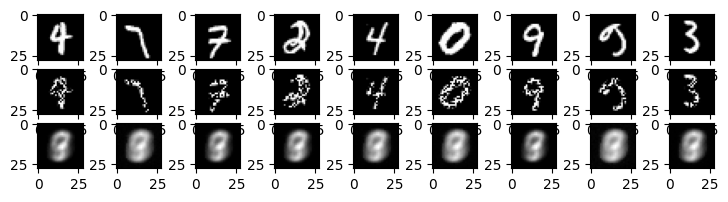

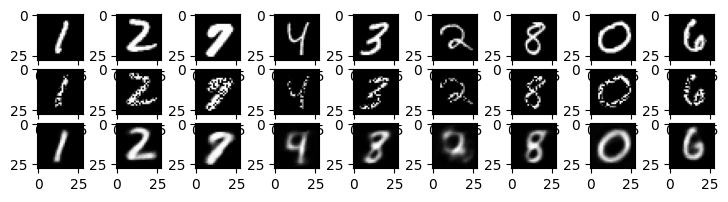

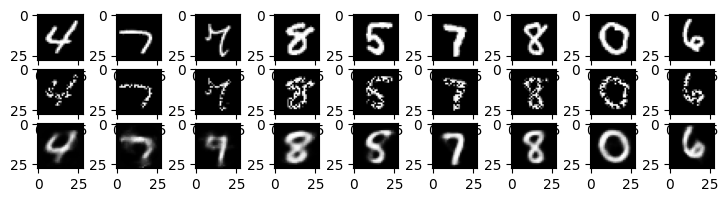

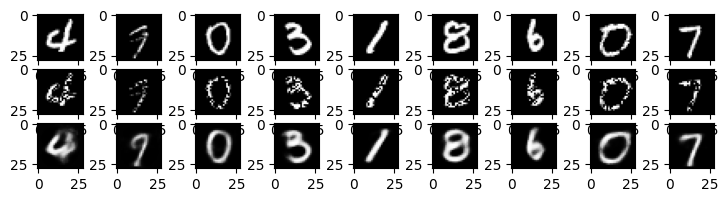

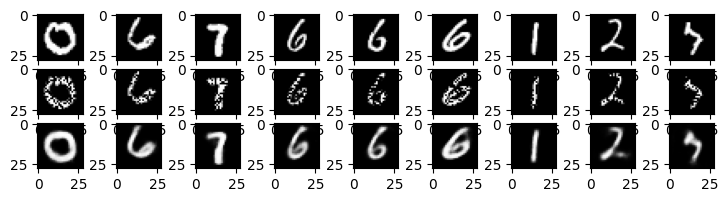

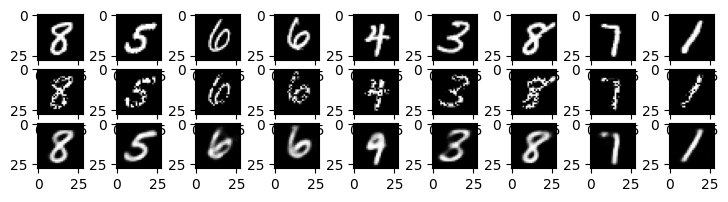

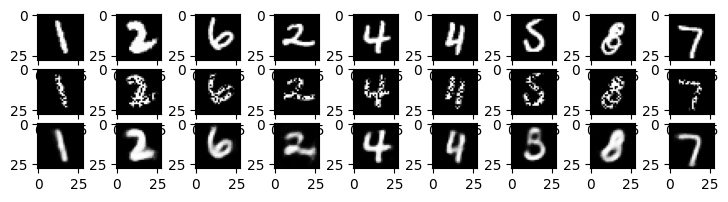

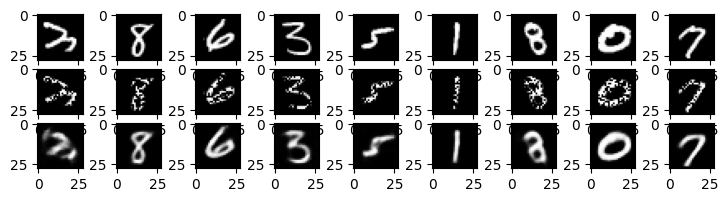

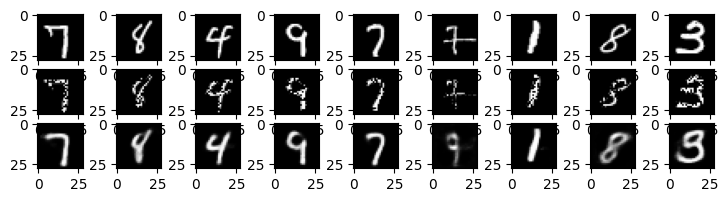

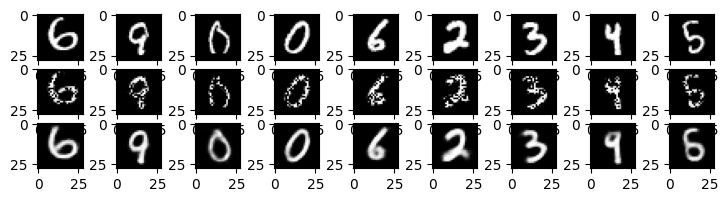

In [ ]:
for k in range(0, num_epochs, 10):
  plt.figure(figsize=(9, 2))
  imgs = outputs[k][1].detach().cpu().numpy()
  noisy_imgs = outputs[k][2].detach().cpu().numpy()
  recon = outputs[k][3].detach().cpu().numpy()

  for i, item in enumerate(imgs):
      if i >= 9: break
      plt.subplot(3, 9, i+1)
      plt.imshow(item.reshape(28, 28), cmap='gray')

  for i, item in enumerate(noisy_imgs):
      if i >= 9: break
      plt.subplot(3, 9, 9+i+1)
      plt.imshow(item.reshape(28, 28), cmap='gray')

  for i, item in enumerate(recon):
      if i >= 9: break
      plt.subplot(3, 9, 18+i+1)
      plt.imshow(item.reshape(28, 28), cmap='gray')
  plt.show()


### Test

In [ ]:
def test(model, test_loader=test_loader):
  model.eval()
  criterion = nn.MSELoss()

  test_loss = 0
  all_imgs, all_noisy_imgs, all_recons = [], [], []

  with torch.no_grad():
      for data in test_loader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)

        recon, noisy_img = model(img)
        loss = criterion(recon, img)
        test_loss += loss.item()

        all_imgs.append(img.cpu())
        all_noisy_imgs.append(noisy_img.cpu())
        all_recons.append(recon.cpu())

  avg_test_loss = test_loss / len(test_loader)
  print(f'Average Test Loss: {avg_test_loss:.4f}')
  return all_imgs, all_noisy_imgs, all_recons


Average Test Loss: 0.0147


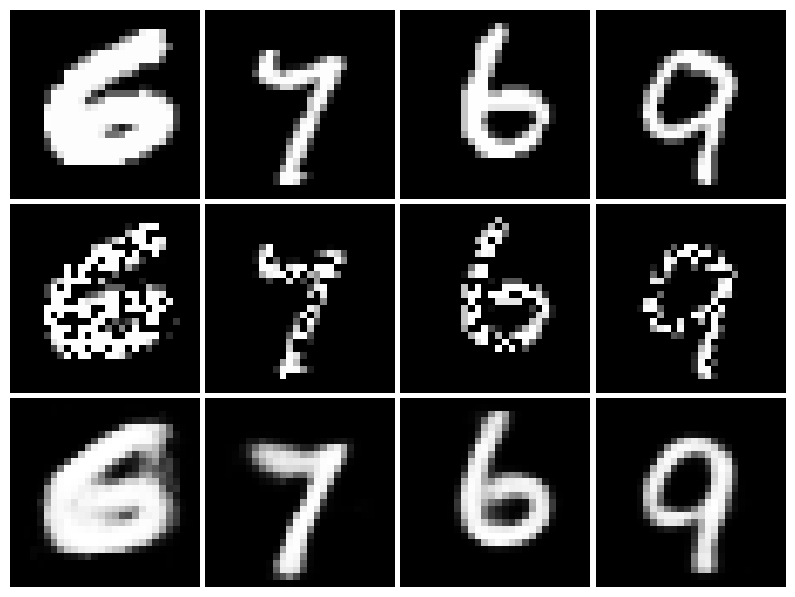

In [ ]:
imgs, noisy_imgs, recons = test(model)

if imgs:
    example_imgs = imgs[0].numpy()
    example_noisy_imgs = noisy_imgs[0].numpy()
    example_recons = recons[0].numpy()

    num_images = min(4, example_imgs.shape[0])  # Adjust the number of images to display

    plt.figure(figsize=(10, 8))  # Adjusted size for better presentation

    for i in range(num_images):
        # Original images
        plt.subplot(3, num_images, i + 1)
        plt.imshow(example_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Noisy images
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(example_noisy_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Reconstructed images
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(example_recons[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.03, hspace=-0.15)
    plt.show()
else:
    print("No images to display.")

## Extension BTC Price Prediction

In [ ]:
import requests
from pytrends.request import TrendReq
from datetime import datetime, timedelta
import time
import yfinance as yf
import pandas as pd
import ta
import nest_asyncio
from sklearn.preprocessing import StandardScaler
import asyncio
import aiohttp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import optuna
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import aiohttp
import matplotlib.pyplot as plt
import itertools
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
import math
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FuncFormatter
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.stats as stats

### Data

In [ ]:
nest_asyncio.apply()

def fetch_data(url, params=None):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    time.sleep(1)
    return None

# Def to fetch data

def get_historical_btc_price(start_date, end_date):
    url = 'https://api.blockchain.info/charts/market-price'
    params = {
        'timespan': 'all',
        'format': 'json',
        'start': start_date,
        'end': end_date,
        'sampled': 'false'
    }
    response = fetch_data(url, params)
    if response and 'values' in response:
        data = pd.DataFrame(response['values'])
        data['date'] = pd.to_datetime(data['x'], unit='s')
        data.set_index('date', inplace=True)
        data = data.loc[start_date:end_date]
        data.rename(columns={'y': 'close'}, inplace=True)
        return data
    return pd.DataFrame()

def get_historical_btc_volume(start_date, end_date):
    url = 'https://api.blockchain.info/charts/trade-volume'
    params = {
        'timespan': 'all',
        'format': 'json',
        'start': start_date,
        'end': end_date,
        'sampled': 'false'
    }
    response = fetch_data(url, params)
    if response and 'values' in response:
        data = pd.DataFrame(response['values'])
        data['date'] = pd.to_datetime(data['x'], unit='s')
        data.set_index('date', inplace=True)
        data = data.loc[start_date:end_date]
        data.rename(columns={'y': 'vol'}, inplace=True)
        return data
    return pd.DataFrame()

def get_blockchain_data(start_date, end_date):
    base_url = 'https://api.blockchain.info/charts'
    data = {}

    charts = [
        'n-transactions', 'n-unique-addresses', 'avg-block-size', 'n-transactions-excluding-popular',
        'estimated-transaction-volume-usd', 'hash-rate', 'difficulty', 'miners-revenue', 'transaction-fees-usd',
        'cost-per-transaction-percent', 'cost-per-transaction', 'output-volume', 'utxo-count', 'median-confirmation-time'
    ]

    for chart in charts:
        url = f'{base_url}/{chart}?timespan=all&start=2013-03-01&format=json&sampled=false'
        response = fetch_data(url)
        if response and 'values' in response:
            chart_data = pd.DataFrame(response['values'])
            chart_data['date'] = pd.to_datetime(chart_data['x'], unit='s')
            chart_data.set_index('date', inplace=True)
            chart_data = chart_data.loc[start_date:end_date]
            chart_data = chart_data.resample('D').sum()
            data[chart] = chart_data['y']
        time.sleep(1)  # Rate limiting
    return data

def get_missing_blockchain(start_date, end_date):
    urls = {
        'mvrv': 'https://api.blockchain.info/charts/mvrv?timespan=all&start=2013-03-01&sampled=false&metadata=false&format=json',
        'nvt': 'https://api.blockchain.info/charts/nvt?timespan=all&start=2013-03-01&sampled=false&metadata=false&format=json',
        'fees_usd_per_transaction': 'https://api.blockchain.info/charts/fees-usd-per-transaction?timespan=all&start=2013-03-01&sampled=false&metadata=false&format=json'
    }

    data = {}

    for name, url in urls.items():
        response = fetch_data(url)
        if response and 'values' in response:
            chart_data = pd.DataFrame(response['values'])
            chart_data['date'] = pd.to_datetime(chart_data['x'], unit='s')
            chart_data.set_index('date', inplace=True)
            chart_data = chart_data.loc[start_date:end_date]
            chart_data = chart_data.resample('D').sum()
            data[name] = chart_data['y']
        else:
            print(f"Failed to fetch data for {name}")
        time.sleep(1)  # Rate limiting

    return data

def get_google_trends_data(keyword, start_date, end_date):
    pytrends = TrendReq(hl='en-US', tz=360, retries=5, backoff_factor=0.5)
    trends_data = pd.DataFrame()

    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')

    while start_dt < end_dt:
        next_dt = start_dt + timedelta(days=30)
        if next_dt > end_dt:
            next_dt = end_dt
        timeframe = f'{start_dt.strftime("%Y-%m-%d")} {next_dt.strftime("%Y-%m-%d")}'

        retry_count = 0
        max_retries = 5
        while retry_count < max_retries:
            try:
                pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='', gprop='')
                df = pytrends.interest_over_time()
                if not df.empty:
                    df = df.drop(labels=['isPartial'], axis='columns')
                    trends_data = pd.concat([trends_data, df])
                break
            except Exception as e:
                retry_count += 1
                wait_time = 2 ** retry_count
                print(f"Error fetching Google Trends data: {e}. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)

        start_dt = next_dt

    return trends_data

def get_financial_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    data['date'] = data.index
    data.set_index('date', inplace=True)
    data = data.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
    data = data.interpolate(method='linear')
    return data

In [ ]:
start_date = '2011-07-01'
end_date = '2024-06-01'
actual_start_date = '2011-07-31'

# Fetch BTC price
btc_data = get_historical_btc_price(start_date, end_date)

# Fetch BTC volume
btc_volume = get_historical_btc_volume(start_date, end_date)

# Fetch Blockchain fundamental indicators
blockchain_data = get_blockchain_data(start_date, end_date)
missing_data = get_missing_blockchain(start_date, end_date)

# Fetch Google Trends data
google_trends_Bitcoin = get_google_trends_data('Bitcoin', start_date, end_date)
google_trends_BTC = get_google_trends_data('BTC', start_date, end_date)

google_trends_Bitcoin = google_trends_Bitcoin[~google_trends_Bitcoin.index.duplicated(keep='first')]
google_trends_BTC = google_trends_BTC[~google_trends_BTC.index.duplicated(keep='first')]

# Fetch financial market data
sp500 = get_financial_data('SPY', start_date, end_date)
nasdaq = get_financial_data('NDX', start_date, end_date)
gold = get_financial_data('GC=F', start_date, end_date)
oil = get_financial_data('CL=F', start_date, end_date)
dow = get_financial_data('DJI', start_date, end_date)
dxy = get_financial_data('DX-Y.NYB', start_date, end_date)
ftse100 = get_financial_data('^FTSE', start_date, end_date)
eurostox = get_financial_data('^STOXX50E', start_date, end_date)
vix = get_financial_data('^VIX', start_date, end_date)
sse = get_financial_data('000001.SS', start_date, end_date)
exchange_rates = {
    'CHFUSD': get_financial_data('CHFUSD=X', start_date, end_date),
    'EURUSD': get_financial_data('EURUSD=X', start_date, end_date),
    'GBPUSD': get_financial_data('GBPUSD=X', start_date, end_date),
    'JPYUSD': get_financial_data('JPYUSD=X', start_date, end_date),
    'CNYUSD': get_financial_data('CNYUSD=X', start_date, end_date)
}

# Calculate Moving Averages
btc_data['SMA_5'] = ta.trend.SMAIndicator(close=btc_data['close'], window=5).sma_indicator()
btc_data['SMA_10'] = ta.trend.SMAIndicator(close=btc_data['close'], window=10).sma_indicator()
btc_data['EMA_9'] = ta.trend.EMAIndicator(close=btc_data['close'], window=9).ema_indicator()

# Volume-based indicators
btc_data['VAMA_9'] = ta.volume.VolumeWeightedAveragePrice(high=btc_data['close'], low=btc_data['close'], close=btc_data['close'], volume=btc_volume['vol'], window=9).volume_weighted_average_price()
btc_data['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=btc_data['close'], low=btc_data['close'], close=btc_data['close'], volume=btc_volume['vol']).volume_weighted_average_price()

# Momentum indicators
btc_data['MOM_10'] = ta.momentum.ROCIndicator(close=btc_data['close'], window=10).roc()
btc_data['MACD'] = ta.trend.MACD(close=btc_data['close']).macd_diff()
btc_data['PERCENT_B'] = ta.volatility.BollingerBands(close=btc_data['close']).bollinger_pband()
btc_data['ROC'] = ta.momentum.ROCIndicator(close=btc_data['close']).roc()

# Oscillators
btc_data['TRIX'] = ta.trend.TRIXIndicator(close=btc_data['close']).trix()
btc_data['RSI'] = ta.momentum.RSIIndicator(close=btc_data['close']).rsi()

# Lagged close prices
for i in range(1, 60):  # Lagged days adjustment
    btc_data[f'Lagged_Close_{i}'] = btc_data['close'].shift(i)


In [ ]:
# Combine all time series data into a single DataFrame
combined_data = pd.DataFrame(index=btc_data.index)

# Adding BTC data
combined_data['BTC_Close'] = btc_data['close']
for i in range(1, 60):
    combined_data[f'BTC_Close_Lag_{i}'] = btc_data[f'Lagged_Close_{i}']

combined_data['BTC_SMA_5'] = btc_data['SMA_5']
combined_data['BTC_SMA_10'] = btc_data['SMA_10']
combined_data['BTC_EMA_9'] = btc_data['EMA_9']
combined_data['BTC_VAMA_9'] = btc_data['VAMA_9']
combined_data['BTC_VWAP'] = btc_data['VWAP']
combined_data['BTC_MOM_10'] = btc_data['MOM_10']
combined_data['BTC_MACD'] = btc_data['MACD']
combined_data['BTC_PERCENT_B'] = btc_data['PERCENT_B']
combined_data['BTC_ROC'] = btc_data['ROC']
combined_data['BTC_TRIX'] = btc_data['TRIX']
combined_data['BTC_RSI'] = btc_data['RSI']

# Adding Blockchain data
for key, series in blockchain_data.items():
    combined_data[key] = series

for key, series in missing_data.items():
    combined_data[key] = series

# Adding Google Trends data
combined_data['Google_Trends_Bitcoin'] = google_trends_Bitcoin['Bitcoin']
combined_data['Google_Trends_BTC'] = google_trends_BTC['BTC']

# Adding Financial market data
combined_data['SP500_Close'] = sp500['Close']
combined_data['NASDAQ_Close'] = nasdaq['Close']
combined_data['Gold_Close'] = gold['Close']
combined_data['Oil_Close'] = oil['Close']
combined_data['Dow_Close'] = dow['Close']
combined_data['DXY_Close'] = dxy['Close']
combined_data['FTSE100_Close'] = ftse100['Close']
combined_data['VIX_Close'] = vix['Close']
combined_data['SSE_Close'] = sse['Close']

financial_data_columns = {}

# Adding Exchange Rates data
for key, df in exchange_rates.items():
    financial_data_columns[f'{key}_Close'] = df['Close']

combined_data = pd.concat([combined_data, pd.DataFrame(financial_data_columns)], axis=1)

# Ensure the combined data is sorted by date
combined_data = combined_data.sort_index()
combined_data = combined_data.shift(1)

# Filter the combined data to start from the actual start date
combined_data = combined_data.loc[actual_start_date:]

# Interpolation for missing values
combined_data = combined_data.interpolate(method='linear')

# Fill remaining missing values with the most frequent value in each column
for column in combined_data.columns:
    if combined_data[column].isnull().any():
        combined_data[column].fillna(combined_data[column].mode()[0], inplace=True)

# Define the target prices
target_prices = btc_data['close'].loc[combined_data.index]

In [ ]:
# Prepare and split data

def get_split_data_for_interval(data, start_date, end_date, train_ratio=0.7, val_ratio=0.15):
    interval_data = data.loc[start_date:end_date]

    train_size = int(len(interval_data) * train_ratio)
    val_size = int(len(interval_data) * val_ratio)
    test_size = len(interval_data) - train_size - val_size

    train_data = interval_data[:train_size]
    val_data = interval_data[train_size:train_size + val_size]
    test_data = interval_data[train_size + val_size:]

    return train_data, val_data, test_data


intervals = {'interval_1': ('2011-08-01', '2015-06-30'),
             'interval_2': ('2015-07-01', '2018-07-31'),
             'interval_3': ('2018-08-01', '2021-11-30'),
             'interval_4': ('2021-12-01', '2024-05-01')}

interval_splits = {}
for key, (start_date, end_date) in intervals.items():
    train_data, val_data, test_data = get_split_data_for_interval(combined_data, start_date, end_date)
    train_target = target_prices.loc[train_data.index]
    val_target = target_prices.loc[val_data.index]
    test_target = target_prices.loc[test_data.index]

    interval_splits[key] = {
        'train_data': train_data,
        'train_target': train_target,
        'val_data': val_data,
        'val_target': val_target,
        'test_data': test_data,
        'test_target': test_target
    }

# Split into the three categories of interest

technical_indicators = [
    'BTC_SMA_5', 'BTC_SMA_10', 'BTC_EMA_9', 'BTC_VAMA_9', 'BTC_VWAP',
    'BTC_MOM_10', 'BTC_MACD', 'BTC_PERCENT_B', 'BTC_ROC', 'BTC_TRIX', 'BTC_RSI'
]

economic_and_blockchain_data = [
    'SP500_Close', 'NASDAQ_Close', 'Gold_Close', 'Oil_Close', 'Dow_Close', 'DXY_Close',
    'FTSE100_Close', 'VIX_Close', 'SSE_Close', 'Google_Trends_Bitcoin', 'Google_Trends_BTC'
] + list(blockchain_data.keys()) + list(missing_data.keys())

lagged_prices = ['BTC_Close'] + [f'BTC_Close_Lag_{i}' for i in range(1, 59)]

full_set_features = technical_indicators + economic_and_blockchain_data + lagged_prices

feature_sets = {
    'technical_indicators': technical_indicators,
    'economic_and_blockchain_data': economic_and_blockchain_data,
    'lagged_prices': lagged_prices,
    'full_set_features': full_set_features
}

def get_features(data, feature_set):
    return data[feature_set]

In [ ]:
# Apply standard scaling to features and targets
standard_scalers = {}
target_standard_scalers = {}

for key, split_data in interval_splits.items():
    train_data = split_data['train_data']
    train_target = split_data['train_target'].values.reshape(-1, 1)

    standard_scaler = StandardScaler()
    target_standard_scaler = StandardScaler()

    split_data['train_data'] = pd.DataFrame(standard_scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    split_data['train_target'] = pd.DataFrame(target_standard_scaler.fit_transform(train_target), index=train_data.index, columns=['BTC_Close'])

    split_data['val_data'] = pd.DataFrame(standard_scaler.transform(split_data['val_data']), index=split_data['val_data'].index, columns=train_data.columns)
    split_data['val_target'] = pd.DataFrame(target_standard_scaler.transform(split_data['val_target'].values.reshape(-1, 1)), index=split_data['val_target'].index, columns=['BTC_Close'])

    split_data['test_data'] = pd.DataFrame(standard_scaler.transform(split_data['test_data']), index=split_data['test_data'].index, columns=train_data.columns)
    split_data['test_target'] = pd.DataFrame(target_standard_scaler.transform(split_data['test_target'].values.reshape(-1, 1)), index=split_data['test_target'].index, columns=['BTC_Close'])

    standard_scalers[key] = standard_scaler
    target_standard_scalers[key] = target_standard_scaler

In [ ]:
# Create DataLoaders

def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data)):
        start_idx = max(0, i - sequence_length + 1)
        seq = data[start_idx:i + 1]
        if len(seq) < sequence_length:
            pad = np.zeros((sequence_length - len(seq), data.shape[1]))
            seq = np.vstack((pad, seq))
        label = target[i]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

def prepare_sequence_data_loader(data, target, sequence_length, batch_size=64, shuffle=False):
    sequences, labels = create_sequences(data.values, target.values, sequence_length)
    tensor_data = torch.tensor(sequences, dtype=torch.float32)
    tensor_target = torch.tensor(labels, dtype=torch.float32).squeeze(-1)
    dataset = TensorDataset(tensor_data, tensor_target)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

def prepare_data_loader(data, target=None, batch_size=64, shuffle=False, for_lstm=False):
    tensor_data = torch.tensor(data.values, dtype=torch.float32)
    if for_lstm:
        tensor_data = tensor_data.unsqueeze(1)
        tensor_target = torch.tensor(target.values, dtype=torch.float32).unsqueeze(-1)
        dataset = TensorDataset(tensor_data, tensor_target)
    else:
        noisy_data = add_gaussian_noise(tensor_data, std=0.4)
        tensor_target = tensor_data
        dataset = TensorDataset(noisy_data, tensor_target)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

### Methodology

#### Feature Selection

In [ ]:
# DAE

class DenoisingAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dims):
    super(DenoisingAutoencoder, self).__init__()

    hidden_dims.sort(reverse=True)

    self.encoder = nn.Sequential()
    for i, hidden_dim in enumerate(hidden_dims):
        self.encoder.add_module(f'enc_{i}', nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim))
        self.encoder.add_module(f'enc_relu_{i}', nn.ReLU())

    self.decoder = nn.Sequential()
    for i, hidden_dim in enumerate(reversed(hidden_dims)):
        self.decoder.add_module(f'dec_{i}', nn.Linear(hidden_dim, input_dim if i == len(hidden_dims)-1 else hidden_dims[-i-2]))
        if i < len(hidden_dims) - 1:
            self.decoder.add_module(f'dec_relu_{i}', nn.ReLU())

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded, encoded

def add_gaussian_noise(tensor, mean=0.0, std=0.1):
  noise = torch.randn(tensor.size()) * std + mean
  noisy_tensor = tensor + noise
  return noisy_tensor

# AE

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Autoencoder, self).__init__()

        hidden_dims.sort(reverse=True)

        self.encoder = nn.Sequential()
        for i, hidden_dim in enumerate(hidden_dims):
            self.encoder.add_module(f'enc_{i}', nn.Linear(input_dim if i == 0 else hidden_dims[i-1], hidden_dim))
            self.encoder.add_module(f'enc_relu_{i}', nn.ReLU())

        self.decoder = nn.Sequential()
        for i, hidden_dim in enumerate(reversed(hidden_dims)):
            self.decoder.add_module(f'dec_{i}', nn.Linear(hidden_dim, input_dim if i == len(hidden_dims)-1 else hidden_dims[-i-2]))
            if i < len(hidden_dims) - 1:
                self.decoder.add_module(f'dec_relu_{i}', nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [ ]:
def suggest_hidden_dims(trial, input_dim, num_hidden_layers):
    hidden_dims = []
    fractions = [2, 3, 4]

    for i in range(num_hidden_layers):
        hidden_dim = trial.suggest_int(
            f'n_units_l{i}',
            math.ceil(input_dim / fractions[i % len(fractions)]),
            math.ceil(input_dim * fractions[i % len(fractions)] / (fractions[i % len(fractions)] + 1))
        )
        hidden_dims.append(hidden_dim)
    return hidden_dims

def objective(trial, feature_set, interval, model_type='dae'):
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 4)
    input_dim = len(feature_set)
    hidden_dims = suggest_hidden_dims(trial, input_dim, num_hidden_layers)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 1000
    patience = 15

    train_data = get_features(interval_splits[interval]['train_data'], feature_set)
    val_data = get_features(interval_splits[interval]['val_data'], feature_set)

    if model_type == 'dae':
        model = DenoisingAutoencoder(input_dim, hidden_dims=hidden_dims).to(device)
    else:
        model = Autoencoder(input_dim, hidden_dims=hidden_dims).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_loader = prepare_data_loader(train_data, batch_size=batch_size, shuffle=False)
    val_loader = prepare_data_loader(val_data, batch_size=batch_size, shuffle=False)

    # Training with Early Stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for noisy_batch, clean_batch in train_loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
            decoded, _ = model(noisy_batch)
            loss = criterion(decoded, clean_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for noisy_batch, clean_batch in val_loader:
                noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
                decoded, _ = model(noisy_batch)
                loss = criterion(decoded, clean_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_val_loss

In [ ]:
# Train

def train_best_model_on_full_data(train_data, best_hidden_dims, best_params, model_type='dae'):
    input_dim = train_data.shape[1]
    epochs = 1000

    if model_type == 'dae':
        best_model = DenoisingAutoencoder(input_dim, hidden_dims=best_hidden_dims).to(device)
    else:
        best_model = Autoencoder(input_dim, hidden_dims=best_hidden_dims).to(device)

    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    criterion = nn.MSELoss()

    full_train_loader = prepare_data_loader(train_data, batch_size=best_params['batch_size'], shuffle=False)

    for epoch in range(epochs):
        best_model.train()
        for noisy_batch, clean_batch in full_train_loader:
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
            decoded, _ = best_model(noisy_batch)
            loss = criterion(decoded, clean_batch)

            best_optimizer.zero_grad()
            loss.backward()
            best_optimizer.step()

    return best_model

# Extract Features

def extract_features(best_model, data, batch_size):
    loader = prepare_data_loader(data, batch_size=batch_size, shuffle=False)
    features = []
    best_model.eval()

    with torch.no_grad():
        for _, clean_batch in loader:
            clean_batch = clean_batch.to(device)
            _, encoded = best_model(clean_batch)
            features.append(encoded.cpu().numpy())

    features = np.concatenate(features, axis=0)
    features_df = pd.DataFrame(features, index=data.index)
    return features_df

#### Price Prediction

In [ ]:
# Moving Average (Benchmark)

def moving_average(data, window=5):
    return data.rolling(window).mean()

def evaluate_moving_average_for_windows(interval_splits, intervals, target_standard_scalers, window_sizes):
    results = []

    for interval in intervals.keys():
        split_data = interval_splits[interval]
        val_test_data = pd.concat([split_data['val_data'], split_data['test_data']])
        val_test_target = pd.concat([split_data['val_target'], split_data['test_target']])

        for window in window_sizes:
            moving_avg_predictions = moving_average(val_test_data['BTC_Close'], window=window).shift(1).dropna()

            moving_avg_predictions = moving_avg_predictions.loc[split_data['test_data'].index]
            moving_avg_target = split_data['test_target'].loc[moving_avg_predictions.index]

            mae, rmse, mape = evaluate_model(moving_avg_target.values, moving_avg_predictions.values, target_standard_scalers[interval])
            results.append((interval, window, mae, rmse, mape))
    return results

# Linear Regression
def linear_regression(train_features, train_target, test_features, test_target, scaler):
    model = LinearRegression()
    model.fit(train_features, train_target)
    predictions = model.predict(test_features)
    mae, rmse, mape = evaluate_model(test_target.values, predictions, scaler)
    return mae, rmse, mape, predictions

# Support Vector Regression (SVR)
def train_svr_with_best_params(features, targets, best_params, sequence_length):
    if sequence_length > 1:
        sequences, targets = create_sequences(features, targets.values.ravel(), sequence_length)
        features = np.reshape(sequences, (sequences.shape[0], -1))
    else:
        targets = targets.values.ravel()
    svr = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])
    svr.fit(features, targets)
    return svr

def evaluate_svr_model(model, test_features, test_target, scaler, sequence_length):
    sequences, _ = create_sequences(test_features.values, test_target.values, sequence_length)
    test_features = np.reshape(sequences, (sequences.shape[0], -1))

    test_predictions = model.predict(test_features)
    mae, rmse, mape = evaluate_model(test_target.values, test_predictions, scaler)
    return mae, rmse, mape, test_predictions

# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        output = self.fc(out)
        return output

def train_lstm_model(train_data, train_target, sequence_length, hidden_dim, best_params):
    model = LSTMModel(input_dim=train_data.shape[1], hidden_dim=hidden_dim[0], dropout_rate=best_params['dropout_rate']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    criterion = nn.MSELoss()
    epochs = 1000
    patience = 30

    combined_train_loader = prepare_sequence_data_loader(train_data, train_target, sequence_length, batch_size=best_params['batch_size'], shuffle=False)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, targets in combined_train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(combined_train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in combined_train_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(combined_train_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return model

def evaluate_lstm_model(model, test_loader, test_target, scaler):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    mae, rmse, mape = evaluate_model(test_target.values, predictions, scaler)

    return mae, rmse, mape, predictions

In [ ]:
# SVR
def svr_objective(trial, feature_set_name, interval, feature_selection):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    epsilon = trial.suggest_float('epsilon', 0.001, 1, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 1, log=True)
    sequence_length = trial.suggest_int('sequence_length', 1, 60)

    split_data = interval_splits[interval]

    train_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['train_data'].index]
    val_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['val_data'].index]

    train_target = split_data['train_target'].values.ravel()
    val_target = split_data['val_target'].values.ravel()

    if sequence_length > 1:
        train_sequences, train_targets = create_sequences(train_features.values, train_target, sequence_length)
        train_features = np.reshape(train_sequences, (train_sequences.shape[0], -1))

        val_sequences, val_targets = create_sequences(val_features.values, val_target, sequence_length)
        val_features = np.reshape(val_sequences, (val_sequences.shape[0], -1))
    else:
        train_targets = train_target
        val_targets = val_target

    svr = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(train_features, train_targets)
    val_predictions = svr.predict(val_features)
    val_loss = mean_squared_error(val_targets, val_predictions)

    return val_loss

# LSTM
def lstm_objective(trial, feature_set_name, interval, feature_selection):
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
    dropout_rate = trial.suggest_float('dropout_rate', 0.001, 0.25)
    hidden_dim = trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256, 512])
    sequence_length = trial.suggest_int('sequence_length', 1, 60)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    patience = 30

    split_data = interval_splits[interval]

    train_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['train_data'].index]
    val_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['val_data'].index]

    train_target = split_data['train_target']
    val_target = split_data['val_target']

    model = LSTMModel(input_dim=train_features.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_loader = prepare_sequence_data_loader(train_features, train_target, sequence_length, batch_size)
    val_loader = prepare_sequence_data_loader(val_features, val_target, sequence_length, batch_size)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1000):
        model.train()
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device).squeeze(-1)
            outputs = model(sequences).squeeze(-1)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device).squeeze(-1)
                outputs = model(sequences).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_val_loss

#### Performance Metrics

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred, scaler):
    y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_true_unscaled = scaler.inverse_transform(y_true.reshape(-1, 1))

    mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
    mape = mean_absolute_percentage_error(y_true_unscaled, y_pred_unscaled)
    return mae, rmse, mape

### Results

In [ ]:
seed = 42
torch.manual_seed(seed)

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

#### Hybrid Framework

##### Feature Selection

In [ ]:
# DAE

# Get best hyperparam and train the best model on the combined dataset

best_models_dae = {}
best_params_dae = {}
best_hidden_dims_dae = {}

best_models_ae = {}
best_params_ae = {}
best_hidden_dims_ae = {}

for feature_set_name, feature_set in feature_sets.items():
    for interval in intervals.keys():
        # DAE Optimization
        dae_study = optuna.create_study(direction='minimize')
        dae_study.optimize(lambda trial: objective(trial, feature_set, interval, model_type='dae'), n_trials=100)

        best_params_dae[(feature_set_name, interval)] = dae_study.best_params
        best_hidden_dims_dae[(feature_set_name, interval)] = [dae_study.best_params[f'n_units_l{i}'] for i in range(dae_study.best_params['num_hidden_layers'])]

        train_data = get_features(interval_splits[interval]['train_data'], feature_set)
        val_data = get_features(interval_splits[interval]['val_data'], feature_set)
        combined_train_data = pd.concat([train_data, val_data])

        best_models_dae[(feature_set_name, interval)] = train_best_model_on_full_data(combined_train_data, best_hidden_dims_dae[(feature_set_name, interval)], best_params_dae[(feature_set_name, interval)], model_type='dae')

        # AE Optimization
        ae_study = optuna.create_study(direction='minimize')
        ae_study.optimize(lambda trial: objective(trial, feature_set, interval, model_type='ae'), n_trials=100)

        best_params_ae[(feature_set_name, interval)] = ae_study.best_params
        best_hidden_dims_ae[(feature_set_name, interval)] = [ae_study.best_params[f'n_units_l{i}'] for i in range(ae_study.best_params['num_hidden_layers'])]

        best_models_ae[(feature_set_name, interval)] = train_best_model_on_full_data(combined_train_data, best_hidden_dims_ae[(feature_set_name, interval)], best_params_ae[(feature_set_name, interval)], model_type='ae')

# Extract features for each interval
features_dict_dae = {}
features_dict_ae = {}

for interval, split_data in interval_splits.items():
    features_dict_dae[interval] = {}
    features_dict_ae[interval] = {}
    for feature_set_name, feature_set in feature_sets.items():
        full_data = get_features(pd.concat([split_data['train_data'], split_data['val_data'], split_data['test_data']]), feature_set)

        features_df_dae = extract_features(best_models_dae[(feature_set_name, interval)], full_data, best_params_dae[(feature_set_name, interval)]['batch_size'])
        features_dict_dae[interval][feature_set_name] = features_df_dae

        features_df_ae = extract_features(best_models_ae[(feature_set_name, interval)], full_data, best_params_ae[(feature_set_name, interval)]['batch_size'])
        features_dict_ae[interval][feature_set_name] = features_df_ae

# Standardize the encoded features
encoded_standard_scalers_dae = {}
encoded_standard_scalers_ae = {}

for interval, split_data in interval_splits.items():
    encoded_standard_scalers_dae[interval] = {}
    encoded_standard_scalers_ae[interval] = {}
    for feature_set_name in feature_sets.keys():
        train_features_dae = features_dict_dae[interval][feature_set_name].loc[split_data['train_data'].index]
        val_features_dae = features_dict_dae[interval][feature_set_name].loc[split_data['val_data'].index]
        test_features_dae = features_dict_dae[interval][feature_set_name].loc[split_data['test_data'].index]

        train_features_ae = features_dict_ae[interval][feature_set_name].loc[split_data['train_data'].index]
        val_features_ae = features_dict_ae[interval][feature_set_name].loc[split_data['val_data'].index]
        test_features_ae = features_dict_ae[interval][feature_set_name].loc[split_data['test_data'].index]

        standard_scaler_dae = StandardScaler()
        standard_scaler_ae = StandardScaler()

        train_features_scaled_dae = pd.DataFrame(standard_scaler_dae.fit_transform(train_features_dae), index=train_features_dae.index, columns=train_features_dae.columns)
        val_features_scaled_dae = pd.DataFrame(standard_scaler_dae.transform(val_features_dae), index=val_features_dae.index, columns=val_features_dae.columns)
        test_features_scaled_dae = pd.DataFrame(standard_scaler_dae.transform(test_features_dae), index=test_features_dae.index, columns=test_features_dae.columns)

        train_features_scaled_ae = pd.DataFrame(standard_scaler_ae.fit_transform(train_features_ae), index=train_features_ae.index, columns=train_features_ae.columns)
        val_features_scaled_ae = pd.DataFrame(standard_scaler_ae.transform(val_features_ae), index=val_features_ae.index, columns=val_features_ae.columns)
        test_features_scaled_ae = pd.DataFrame(standard_scaler_ae.transform(test_features_ae), index=test_features_ae.index, columns=test_features_ae.columns)

        features_dict_dae[interval][feature_set_name].loc[train_features_dae.index] = train_features_scaled_dae
        features_dict_dae[interval][feature_set_name].loc[val_features_dae.index] = val_features_scaled_dae
        features_dict_dae[interval][feature_set_name].loc[test_features_dae.index] = test_features_scaled_dae

        features_dict_ae[interval][feature_set_name].loc[train_features_ae.index] = train_features_scaled_ae
        features_dict_ae[interval][feature_set_name].loc[val_features_ae.index] = val_features_scaled_ae
        features_dict_ae[interval][feature_set_name].loc[test_features_ae.index] = test_features_scaled_ae

features_dict = {
    'no_feature_selection': {},
    'dae': features_dict_dae,
    'ae': features_dict_ae
}

##### Price Prediction

In [ ]:
best_svr_params = {}
best_lstm_params = {}
best_lstm_hidden_dims = {}

for feature_set_name in feature_sets.keys():
    for interval in intervals.keys():
        for feature_selection in ['no_feature_selection', 'dae', 'ae']:

            if feature_selection == 'no_feature_selection':
                train_data = get_features(interval_splits[interval]['train_data'], feature_sets[feature_set_name])
                val_data = get_features(interval_splits[interval]['val_data'], feature_sets[feature_set_name])
                test_data = get_features(interval_splits[interval]['test_data'], feature_sets[feature_set_name])

                features_dict['no_feature_selection'][interval] = {feature_set_name: pd.concat([train_data, val_data, test_data])}
                features_dict['no_feature_selection'][interval][feature_set_name] = features_dict['no_feature_selection'][interval][feature_set_name].sort_index()

            # SVR Optimization
            svr_study = optuna.create_study(direction='minimize')
            svr_study.optimize(lambda trial: svr_objective(trial, feature_set_name, interval, feature_selection), n_trials=100)
            best_svr_params[(feature_set_name, interval, feature_selection)] = svr_study.best_params
            print(f"Best SVR parameters for {feature_set_name} in {interval} with {feature_selection}: {best_svr_params[(feature_set_name, interval, feature_selection)]}")

            # LSTM Optimization
            lstm_study = optuna.create_study(direction='minimize')
            lstm_study.optimize(lambda trial: lstm_objective(trial, feature_set_name, interval, feature_selection), n_trials=100)
            best_lstm_params[(feature_set_name, interval, feature_selection)] = lstm_study.best_params
            best_lstm_hidden_dims[(feature_set_name, interval, feature_selection)] = [best_lstm_params[(feature_set_name, interval, feature_selection)]['hidden_dim']]
            print(f"Best LSTM parameters for {feature_set_name} in {interval} with {feature_selection}: {best_lstm_params[(feature_set_name, interval, feature_selection)]}")

In [ ]:
results_df = pd.DataFrame(columns=['Interval', 'Model', 'MAE', 'RMSE', 'MAPE'])
results_list = []
predictions_dict = {}

# Training and evaluation loop
for interval in intervals.keys():
    split_data = interval_splits[interval]

    for feature_set_name in feature_sets.keys():
        for feature_selection in ['no_feature_selection', 'dae', 'ae']:
            if feature_selection == 'no_feature_selection':
                train_features = get_features(split_data['train_data'], feature_sets[feature_set_name])
                val_features = get_features(split_data['val_data'], feature_sets[feature_set_name])
                test_features = get_features(split_data['test_data'], feature_sets[feature_set_name])
                combined_train_val_features = pd.concat([train_features, val_features])
            else:
                train_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['train_data'].index]
                val_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['val_data'].index]
                test_features = features_dict[feature_selection][interval][feature_set_name].loc[split_data['test_data'].index]
                combined_train_val_features = pd.concat([train_features, val_features])

            combined_train_val_target = pd.concat([split_data['train_target'], split_data['val_target']])

            # Linear Regression
            lr_mae, lr_rmse, lr_mape, lr_predictions = linear_regression(combined_train_val_features, combined_train_val_target, test_features, split_data['test_target'], target_standard_scalers[interval])
            print(f"Linear Regression ({interval} - {feature_set_name} with {feature_selection}) - Test MAE: {lr_mae}, Test RMSE: {lr_rmse}, Test MAPE: {lr_mape}")
            results_list.append({'Interval': interval, 'Model': 'Linear Regression', 'MAE': lr_mae, 'RMSE': lr_rmse, 'MAPE': lr_mape})
            predictions_dict[(interval, 'Linear Regression', feature_set_name, feature_selection)] = lr_predictions

            # SVR
            best_svr_model = train_svr_with_best_params(combined_train_val_features, combined_train_val_target, best_svr_params[(feature_set_name, interval, feature_selection)], sequence_length=best_svr_params[(feature_set_name, interval, feature_selection)]['sequence_length'])
            svr_mae, svr_rmse, svr_mape, svr_predictions = evaluate_svr_model(best_svr_model, test_features, split_data['test_target'], target_standard_scalers[interval], sequence_length=best_svr_params[(feature_set_name, interval, feature_selection)]['sequence_length'])
            print(f"SVR ({interval} - {feature_set_name} with {feature_selection}) - Test MAE: {svr_mae}, Test RMSE: {svr_rmse}, Test MAPE: {svr_mape}")
            results_list.append({'Interval': interval, 'Model': 'SVR', 'MAE': svr_mae, 'RMSE': svr_rmse, 'MAPE': svr_mape})
            predictions_dict[(interval, 'SVR', feature_set_name, feature_selection)] = svr_predictions

            # LSTM
            best_lstm_model = train_lstm_model(combined_train_val_features, combined_train_val_target, best_lstm_params[(feature_set_name, interval, feature_selection)]['sequence_length'], best_lstm_hidden_dims[(feature_set_name, interval, feature_selection)], best_lstm_params[(feature_set_name, interval, feature_selection)])
            test_loader = prepare_sequence_data_loader(test_features, split_data['test_target'], best_lstm_params[(feature_set_name, interval, feature_selection)]['sequence_length'], batch_size=best_lstm_params[(feature_set_name, interval, feature_selection)]['batch_size'], shuffle=False)
            lstm_mae, lstm_rmse, lstm_mape, lstm_predictions = evaluate_lstm_model(best_lstm_model, test_loader, split_data['test_target'], target_standard_scalers[interval])
            print(f"LSTM ({interval} - {feature_set_name} with {feature_selection}) - Test MAE: {lstm_mae}, Test RMSE: {lstm_rmse}, Test MAPE: {lstm_mape}")
            results_list.append({'Interval': interval, 'Model': 'LSTM', 'MAE': lstm_mae, 'RMSE': lstm_rmse, 'MAPE': lstm_mape})
            predictions_dict[(interval, 'LSTM', feature_set_name, feature_selection)] = lstm_predictions

results_df = pd.DataFrame(results_list)
for model, group in results_df.groupby('Model'):
    print(f"Results for {model}:")
    for index, row in group.iterrows():
        print(f"Interval: {row['Interval']}, Feature Set: {row['Feature Set']}, Feature Selection: {row['Feature Selection']}")
        print(f"MAE: {row['MAE']}, RMSE: {row['RMSE']}, MAPE: {row['MAPE']}%")
        print("-" * 40)

#### Moving Average

In [ ]:
# Moving Average Benchmark
window_sizes = [2, 3, 4, 5, 6, 7, 14, 30, 60]
ma_results = evaluate_moving_average_for_windows(interval_splits, intervals, target_standard_scalers, window_sizes)

ma_results_df = pd.DataFrame(ma_results, columns=['Interval', 'Window', 'MAE', 'RMSE', 'MAPE'])
print(ma_results_df)

#### Plots

##### Moving Average

In [ ]:
# Moving Average Plots (Precitions vs Real)

def inverse_transform_predictions(scaler, predictions):
    return scaler.inverse_transform(predictions.values.reshape(-1, 1)).flatten()

def plot_moving_averages(interval, actual_prices, ma_predictions, window_sizes, scaler):
    plt.figure(figsize=(14, 8))
    unscaled_actual_prices = inverse_transform_predictions(scaler, actual_prices)
    plt.plot(actual_prices.index, unscaled_actual_prices, label='Actual Prices', color='blue')

    for window_size, predictions in ma_predictions.items():
        unscaled_predictions = inverse_transform_predictions(scaler, predictions)
        plt.plot(predictions.index, unscaled_predictions, label=f'MA {window_size} Predictions')

    plt.xlabel('Time')
    plt.ylabel('BTC Price')
    plt.title(f'Moving Averages Predictions vs Actual Prices ({interval})')
    plt.legend()
    plt.show()

for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices = split_data['test_target']
    ma_predictions = {}

    for window_size in window_sizes:
        ma_predictions[window_size] = moving_average(split_data['test_data']['BTC_Close'], window=window_size).dropna()

    plot_moving_averages(interval, actual_prices, ma_predictions, window_sizes, target_standard_scalers[interval])

In [ ]:
from scipy.stats import norm

# Error distribution for each interval

def plot_error_distribution_with_standard_normal(interval, actual_prices, ma_predictions, scaler):
    plt.figure(figsize=(14, 8))
    for window_size, predictions in ma_predictions.items():
        unscaled_predictions = inverse_transform_predictions(scaler, predictions)
        unscaled_actual_prices = inverse_transform_predictions(scaler, actual_prices.loc[predictions.index])
        errors = unscaled_actual_prices - unscaled_predictions
        sns.kdeplot(errors, label=f'MA {window_size} Errors', fill=True)

    plt.xlabel('Prediction Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Generate and plot error distribution for each interval
for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices = split_data['test_target']
    ma_predictions = {}

    for window_size in window_sizes:
        ma_predictions[window_size] = moving_average(split_data['test_data']['BTC_Close'], window=window_size).dropna()

    plot_error_distribution_with_standard_normal(interval, actual_prices, ma_predictions, target_standard_scalers[interval])

In [ ]:
# Performance metrics over time for each interval

def plot_metrics_over_time(interval, actual_prices, ma_predictions, scaler):
    metrics_df = pd.DataFrame(index=actual_prices.index)
    unscaled_actual_prices = inverse_transform_predictions(scaler, actual_prices)

    for window_size, predictions in ma_predictions.items():
        unscaled_predictions = inverse_transform_predictions(scaler, predictions)
        metrics_df[f'MA_{window_size}_MAE'] = abs(unscaled_actual_prices - unscaled_predictions)
        metrics_df[f'MA_{window_size}_RMSE'] = (unscaled_actual_prices - unscaled_predictions) ** 2
        metrics_df[f'MA_{window_size}_MAPE'] = abs((unscaled_actual_prices - unscaled_predictions) / unscaled_actual_prices) * 100

    plt.figure(figsize=(14, 8))
    for window_size in window_sizes:
        plt.plot(metrics_df.index, metrics_df[f'MA_{window_size}_MAE'], label=f'MA {window_size} MAE')

    plt.xlabel('Time')
    plt.ylabel('MAE')
    plt.title(f'MAE Over Time for Moving Averages ({interval})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 8))
    for window_size in window_sizes:
        plt.plot(metrics_df.index, metrics_df[f'MA_{window_size}_RMSE'], label=f'MA {window_size} RMSE')

    plt.xlabel('Time')
    plt.ylabel('RMSE')
    plt.title(f'RMSE Over Time for Moving Averages ({interval})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 8))
    for window_size in window_sizes:
        plt.plot(metrics_df.index, metrics_df[f'MA_{window_size}_MAPE'], label=f'MA {window_size} MAPE')

    plt.xlabel('Time')
    plt.ylabel('MAPE')
    plt.title(f'MAPE Over Time for Moving Averages ({interval})')
    plt.legend()
    plt.show()

for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices = split_data['test_target']
    ma_predictions = {}

    for window_size in window_sizes:
        ma_predictions[window_size] = moving_average(split_data['test_data']['BTC_Close'], window=window_size).dropna()

    plot_metrics_over_time(interval, actual_prices, ma_predictions, target_standard_scalers[interval])


In [ ]:
# Residuals Over Time

def plot_residuals_over_time(interval, actual_prices, ma_predictions, scaler):
    plt.figure(figsize=(14, 8))
    unscaled_actual_prices = inverse_transform_predictions(scaler, actual_prices)

    for window_size, predictions in ma_predictions.items():
        unscaled_predictions = inverse_transform_predictions(scaler, predictions)
        residuals = unscaled_actual_prices - unscaled_predictions
        plt.plot(predictions.index, residuals, label=f'MA {window_size} Residuals')

    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Over Time for Moving Averages ({interval})')
    plt.legend()
    plt.show()

for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices = split_data['test_target']
    ma_predictions = {}

    for window_size in window_sizes:
        ma_predictions[window_size] = moving_average(split_data['test_data']['BTC_Close'], window=window_size).dropna()

    plot_residuals_over_time(interval, actual_prices, ma_predictions, target_standard_scalers[interval])


##### Other models

In [ ]:
import os

# Predicted vs Real

def unscale_predictions(predictions, scaler):
    return scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

def plot_all_predictions(interval, feature_set, feature_selection, actual_prices, predictions_dict, dates, scaler):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual_prices, label='Actual Prices', color='black', linewidth = 3)


    for model in ['Linear Regression', 'SVR', 'LSTM']:
        predicted_prices_scaled = predictions_dict[(interval, model, feature_set, feature_selection)]
        predicted_prices = predicted_prices_scaled
        plt.plot(dates, predicted_prices, label=f'{model} Predictions', linewidth = 2)

    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.legend()
    plt.tight_layout()
    # Save the plot in the 'Graphs' directory
    filename = f'Graph/Comparison/{interval}_{feature_set}_{feature_selection}.png'
    plt.savefig(filename)
    plt.close()

if not os.path.exists('Graph/Comparison'):
    os.makedirs('Graph/Comparison')

# Predictions vs Real for each interval
for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices_scaled = split_data['test_target'].values
    actual_prices = unscale_predictions(actual_prices_scaled, target_standard_scalers[interval])
    dates = split_data['test_data'].index  # Extract dates from the test data index

    for feature_set_name in feature_sets.keys():
        for feature_selection in ['no_feature_selection', 'dae', 'ae']:
            plot_all_predictions(interval, feature_set_name, feature_selection, actual_prices, predictions_dict, dates, target_standard_scalers[interval])


In [ ]:
# Function to plot DAE vs AE predictions for noise reduction comparison
def plot_dae_vs_ae(interval, feature_set, actual_prices, predictions_dict, dates, scaler):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual_prices, label='Actual Prices', color='black', linewidth=3)

    for model in ['Linear Regression', 'SVR', 'LSTM']:
        # DAE Predictions
        predicted_prices_dae_scaled = predictions_dict[(interval, model, feature_set, 'dae')]
        predicted_prices_dae = predicted_prices_dae_scaled
        plt.plot(dates, predicted_prices_dae, linestyle='-', label=f'{model} DAE Predictions', linewidth=2)

        # AE Predictions
        predicted_prices_ae_scaled = predictions_dict[(interval, model, feature_set, 'ae')]
        predicted_prices_ae = predicted_prices_ae_scaled
        plt.plot(dates, predicted_prices_ae, linestyle='--', label=f'{model} AE Predictions', linewidth=2)

    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.legend()
    plt.tight_layout()

    filename = f'Graph/DAE_vs_AE/{interval}_{feature_set}_DAE_vs_AE.png'
    plt.savefig(filename)
    plt.close()

if not os.path.exists('Graph/DAE_vs_AE'):
    os.makedirs('Graph/DAE_vs_AE')

# Predictions vs Real for each interval
for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices_scaled = split_data['test_target'].values
    actual_prices = unscale_predictions(actual_prices_scaled, target_standard_scalers[interval])
    dates = split_data['test_data'].index  # Extract dates from the test data index

    for feature_set_name in feature_sets.keys():
        plot_dae_vs_ae(interval, feature_set_name, actual_prices, predictions_dict, dates, target_standard_scalers[interval])

In [ ]:
# Function to plot DAE vs AE predictions for noise reduction comparison for all models within the same plot
def plot_dae_vs_ae_all_models(interval, actual_prices, predictions_dict, dates, scaler, output_dir="plots"):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, actual_prices, label='Actual Prices', color='black', linewidth=2)

    for model in ['Linear Regression', 'SVR', 'LSTM']:
        # DAE Predictions
        predicted_prices_dae_scaled = predictions_dict[(interval, model, 'full_set_features', 'dae')]
        predicted_prices_dae = predicted_prices_dae_scaled
        plt.plot(dates, predicted_prices_dae, linestyle='-', label=f'{model} DAE Predictions', linewidth=1.5)

        # AE Predictions
        predicted_prices_ae_scaled = predictions_dict[(interval, model, 'full_set_features', 'ae')]
        predicted_prices_ae = predicted_prices_ae_scaled
        plt.plot(dates, predicted_prices_ae, linestyle='--', label=f'{model} AE Predictions', linewidth=1.5)

    plt.xlabel('Date')
    plt.ylabel('BTC Price')
    plt.title(f'Actual vs Predicted Prices ({interval} - DAE vs AE)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate and save the plots
for interval in intervals.keys():
    split_data = interval_splits[interval]
    actual_prices_scaled = split_data['test_target'].values
    actual_prices = unscale_predictions(actual_prices_scaled, target_standard_scalers[interval])
    dates = split_data['test_data'].index  # Extract dates from the test data index

    plot_dae_vs_ae_all_models(interval, actual_prices, predictions_dict, dates, target_standard_scalers[interval])

### Extra

In [ ]:
# Plots for DATA SECTION

# Price and Volume In Entire Range

intervals = {k: (pd.to_datetime(v[0]), pd.to_datetime(v[1])) for k, v in intervals.items()}

fig, ax1 = plt.subplots(figsize=(14, 8))

line1, = ax1.plot(btc_data.index, btc_data['close'], label='BTC Price', color='tab:blue', linewidth=2)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('BTC Price (USD)', fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax2 = ax1.twinx()
line2, = ax2.plot(btc_volume.index, btc_volume['vol'], label='BTC Volume', color='tab:orange', linewidth=2, alpha=0.6)
ax2.set_ylabel('BTC Trading Volume (Billion USD)', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

for label, (start, end) in intervals.items():
    ax1.axvline(x=start, color='black', linestyle='--', linewidth=1)
    ax1.axvline(x=end, color='black', linestyle='--', linewidth=1)
    mid_date = start + (end - start) / 2
    ax1.text(mid_date, ax1.get_ylim()[1] * 0.95, label.replace('_', ' ').title(),
             horizontalalignment='center', fontsize=10, color='black', weight='bold')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)
fig.tight_layout()
plt.show()

# Plot each interval separately

padding_percentage = 0.1

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, (label, (start, end)) in enumerate(intervals.items()):
    ax1 = axs[i]

    if i == 0:
      line1, = ax1.plot(btc_data.index, btc_data['close'], label='BTC Price', color='tab:blue', linewidth=2)
      ax1.set_xlabel('Date', fontsize=12)
      ax1.set_ylabel('BTC Price (USD)', fontsize=12)
      ax1.tick_params(axis='y')

      ax2 = ax1.twinx()
      line2, = ax2.plot(btc_volume.index, btc_volume['vol'], label='BTC Volume', color='tab:orange', linewidth=2, alpha=0.6)

      if i == 0:
          ax2.set_ylabel('BTC Trading Volume ($10^7$ USD)', fontsize=12)
      else:
          ax2.set_ylabel('BTC Trading Volume (Billion USD)', fontsize=12)

      ax2.tick_params(axis='y')

      ax1.set_xlim(start, end)
      price_min = btc_data['close'].loc[start:end].min()
      price_max = btc_data['close'].loc[start:end].max()
      volume_min = btc_volume['vol'].loc[start:end].min()
      volume_max = btc_volume['vol'].loc[start:end].max()

      ax1.set_ylim(price_min * (1 - padding_percentage), price_max * (1 + padding_percentage))
      ax2.set_ylim(0, volume_max * (1 + padding_percentage))

      ax1.axvline(x=start, color='grey', linestyle='--', linewidth=1)
      ax1.axvline(x=end, color='grey', linestyle='--', linewidth=1)
      mid_date = start + (end - start) / 2
      ax1.text(mid_date, ax1.get_ylim()[1] * 0.95, label.replace('_', ' ').title(),
              horizontalalignment='center', fontsize=10, color='black', weight='bold')

      ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
      ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

      ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

      lines = [line1, line2]
      labels = [line.get_label() for line in lines]
      ax1.legend(lines, labels, loc='upper left', fontsize=10)

fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [ ]:
# LR Model Validity

from scipy.stats import norm

def check_model_validity(model, features, target):
    predictions = model.predict(features)
    residuals = target - predictions

    # Durbin-Watson Test
    dw_test = durbin_watson(residuals)

    # White's Test
    exog = sm.add_constant(features)
    white_test = het_white(residuals, exog)

    # Jarque-Bera Test
    jb_test = jarque_bera(residuals)

    # Interpretation of test results
    alpha = 0.05  # significance level

    dw_result = "Reject" if dw_test < 1.5 or dw_test > 2.5 else "Accept"
    white_result = "Reject" if white_test[1] < alpha else "Accept"
    jb_result = "Reject" if jb_test[1] < alpha else "Accept"

    # Create a table for the test results
    test_results = {
        'Test': ['Durbin-Watson', 'White', 'Jarque-Bera'],
        'Statistic': [dw_test, white_test[0], jb_test[0]],
        'p-value': ['-', white_test[1], jb_test[1]],
        'Decision': [dw_result, white_result, jb_result]
    }
    results_df = pd.DataFrame(test_results)

    # Plotting Residuals
    plt.figure(figsize=(12, 6))

    # Histogram with Kernel
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, bins=20, kde=True, color='darkblue', stat="density", label='Residual Histogram')
    mu, std = norm.fit(residuals)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')
    plt.legend(['Kernel', 'Normal Distribution', 'Residual Histogram'])

    return results_df

# Assuming interval_splits and feature_sets are predefined
all_results = []

for interval in intervals.keys():
    split_data = interval_splits[interval]

    for feature_set_name in feature_sets.keys():
        train_features = get_features(split_data['train_data'], feature_sets[feature_set_name])
        val_features = get_features(split_data['val_data'], feature_sets[feature_set_name])
        test_features = get_features(split_data['test_data'], feature_sets[feature_set_name])
        combined_train_val_features = pd.concat([train_features, val_features])
        combined_train_val_target = pd.concat([split_data['train_target'], split_data['val_target']])

        lr_model = LinearRegression().fit(combined_train_val_features, combined_train_val_target)

        print(f"Results for Interval: {interval}, Feature Set: {feature_set_name}")
        results_df = check_model_validity(lr_model, test_features, split_data['test_target'])
        all_results.append((interval, feature_set_name, results_df))

print(all_results)

In [ ]:
import shutil
import zipfile
from google.colab import files

# Define the folder path you want to zip and download
folder_to_zip = 'Graph'
output_filename = 'Graphs.zip'

# Zip the folder
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

# Download the zipped folder
files.download(output_filename)
